In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

### The first step in the process is to compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [3]:
def get_distortion_parameters():
    nx = 9
    ny = 6

    imgpoints = []
    objpoints= []
    objp = np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for name in os.listdir("camera_cal/"):
        img = mpimg.imread('camera_cal/'+name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [4]:
mtx, dist = get_distortion_parameters()
print(mtx, dist)

[[  1.15662906e+03   0.00000000e+00   6.69041437e+02]
 [  0.00000000e+00   1.15169194e+03   3.88137239e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] [[-0.2315715  -0.12000538 -0.00118338  0.00023305  0.15641572]]


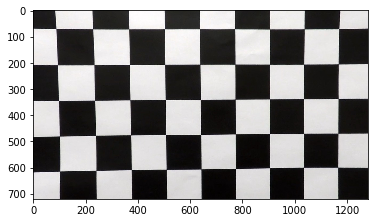

In [24]:
cal_img = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(cal_img)
cal_img = cv2.undistort(cal_img, mtx, dist, None, mtx)
plt.imshow(cal_img)
mpimg.imsave('output_images/undistorted_calibration1.jpg', cal_img)

### We will then write a function for the pipeline that:
##### 1) Applies a distortion correction to raw images.
##### 2) Use color transforms, gradients, etc., to create a thresholded binary image.
here is an undistorted image example:

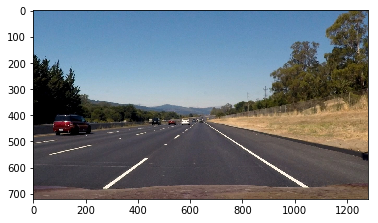

In [5]:
image = mpimg.imread('test_images/straight_lines2.jpg')
plt.imshow(image)


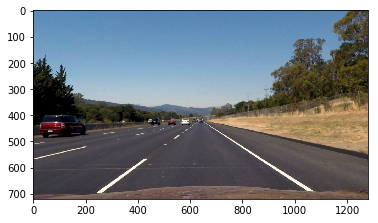

In [6]:
image = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(image)
mpimg.imsave('output_images/undistorted_straight_lines2.jpg', image)

In [7]:
def get_binary_threshold(img,mtx,dist,thresh):
    img = np.copy(img)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

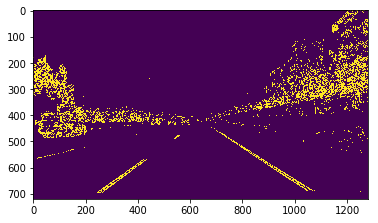

In [9]:
thresh= (15, 200)
bimage = get_binary_threshold(image,mtx,dist,thresh)
plt.imshow(bimage)
mpimg.imsave('output_images/thresholded_binary_straight_lines2.jpg', bimage)

### We then write a method to apply a perspective transform to rectify binary image ("birds-eye view").

In [10]:
def get_birds_eye_view(img):
    src = []
    dst = []
    horizon =450
    
    src.append([img.shape[1]/2-50,horizon])
    src.append([img.shape[1]/2+50,horizon])
    src.append([img.shape[1]/2-450,img.shape[0]])
    src.append([img.shape[1]/2+450,img.shape[0]])

    dst.append([img.shape[1]/2 - 300, 0])
    dst.append([img.shape[1]/2 + 300, 0])
    dst.append([img.shape[1]/2 - 300, img.shape[0]])
    dst.append([img.shape[1]/2 + 300, img.shape[0]])
    
    src = np.float32(src)
    dst = np.float32(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    M_t = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    return warped, M_t

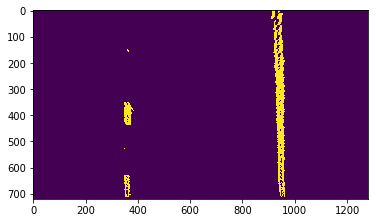

In [11]:
bimage, M_t = get_birds_eye_view(bimage)
plt.imshow(bimage)
mpimg.imsave('output_images/birds_eye_view_straight_lines2.jpg', bimage)

### We then make a Line class to keep track of lines

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

### Then, we write two methods
#### the first one detects lane pixels using a sliding window.
#### the second one detects lane pixels using the previous fit.
### Then we'll make a method to select between these methods and fit it to a polynomial

In [13]:
# method reused from quiz
def sliding_window(img, nwindows = 9, margin = 100, minpix = 50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(img.shape[0]//nwindows)
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [14]:
def from_prior(img,left,right,margin=100):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left[0]*(nonzeroy**2) + left[1]*nonzeroy + 
                    left[2] - margin)) & (nonzerox < (left[0]*(nonzeroy**2) + 
                    left[1]*nonzeroy + left[2] + margin)))
    right_lane_inds = ((nonzerox > (right[0]*(nonzeroy**2) + right[1]*nonzeroy + 
                    right[2] - margin)) & (nonzerox < (right[0]*(nonzeroy**2) + 
                    right[1]*nonzeroy + right[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [15]:
def fit_polynomial(img,left,right,ym_per_pix = 30/720, xm_per_pix = 3.7/700):

    if(left.detected and right.detected):
        leftx, lefty, rightx, righty = from_prior(img,left.current_fit,right.current_fit)
    if(not left.detected or not right.detected):
        leftx, lefty, rightx, righty = sliding_window(img)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        left.detected = True
        right.detected = True 
        
        right.recent_xfitted.append(right_fitx)
        left.recent_xfitted.append(left_fitx)
        
        right.current_fit = right_fit  
        left.current_fit = left_fit  
        
        left.radius_of_curvature = ((1 + (2*left.current_fit[0]*np.max(lefty)*ym_per_pix + left.current_fit[1])**2)**1.5) / np.absolute(2*left.current_fit[0])
        right.radius_of_curvature = ((1 + (2*right.current_fit[0]*np.max(righty)*ym_per_pix + right.current_fit[1])**2)**1.5) / np.absolute(2*right.current_fit[0])

        right.line_base_pos = (right_fit[0]*rightx[0]**2 + right_fit[1]*rightx[0] + right_fit[2])*xm_per_pix
        left.line_base_pos = (left_fit[0]*leftx[0]**2 + left_fit[1]*leftx[0] + left_fit[2])*xm_per_pix
        
        left.allx = left_fitx 
        left.ally = ploty
        right.allx = right_fitx  
        right.ally = ploty  
        
    except TypeError:
        left.detected = False
        right.detected = False
        
        left.current_fit = [np.array([False])]
        right.current_fit = [np.array([False])]
        
        left.radius_of_curvature = None 
        right.radius_of_curvature = None 
        
        right.line_base_pos = None 
        left.line_base_pos = None
        
        left.allx = None 
        left.ally = None
        right.allx = None  
        right.ally = None 

    return left, right

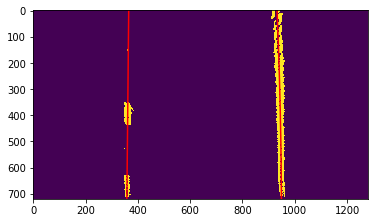

In [17]:
left, right = fit_polynomial(bimage, Line(), Line())
plt.plot(left.allx, left.ally, color='red')
plt.plot(right.allx, right.ally, color='red')
plt.imshow(bimage)
mpimg.imsave('output_images/polynomial_fitted_straight_lines2.jpg', bimage)

### The next step is to make a function such that we warp the detected lane boundaries back onto the original image and output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [18]:
def warp_to_original(img,left,right,M):
    color_warp = np.zeros_like(img).astype(np.uint8)

    print(color_warp.shape)
    pts_left = np.array([np.transpose(np.vstack([left.allx, left.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right.allx, right.ally])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, M, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

(720, 1280, 3)


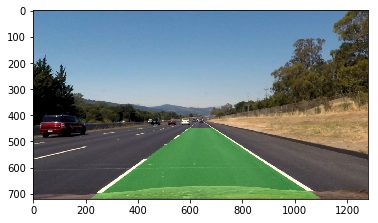

In [19]:
image = warp_to_original(image,left,right,M_t)
plt.imshow(image)
mpimg.imsave('output_images/final_straight_lines2.jpg', image)

### Let use put all of this into a defined pipeline and process a video

In [20]:
mtx,dist = get_distortion_parameters()
thresh= (15, 200)
def process_image(image):
    cv2.undistort(image,mtx,dist, None,mtx)
    bimage = get_binary_threshold(image,mtx,dist,thresh)
    bimage, M_t = get_birds_eye_view(bimage)
    left, right = fit_polynomial(bimage, Line(), Line())
    image = warp_to_original(image,left,right,M_t)
    return image

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_video_output.mp4'
white_input = 'project_video.mp4'
clip1 = VideoFileClip(white_input)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

(720, 1280, 3)
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 1/1261 [00:00<02:28,  8.46it/s]

(720, 1280, 3)


  0%|          | 2/1261 [00:00<02:41,  7.82it/s]

(720, 1280, 3)


  0%|          | 3/1261 [00:00<02:39,  7.89it/s]

(720, 1280, 3)


  0%|          | 4/1261 [00:00<02:39,  7.87it/s]

(720, 1280, 3)


  0%|          | 5/1261 [00:00<02:38,  7.93it/s]

(720, 1280, 3)


  0%|          | 6/1261 [00:00<02:39,  7.89it/s]

(720, 1280, 3)


  1%|          | 7/1261 [00:00<02:37,  7.94it/s]

(720, 1280, 3)


  1%|          | 8/1261 [00:01<02:38,  7.90it/s]

(720, 1280, 3)


  1%|          | 9/1261 [00:01<02:39,  7.85it/s]

(720, 1280, 3)


  1%|          | 10/1261 [00:01<02:37,  7.94it/s]

(720, 1280, 3)


  1%|          | 11/1261 [00:01<02:38,  7.90it/s]

(720, 1280, 3)


  1%|          | 12/1261 [00:01<02:37,  7.95it/s]

(720, 1280, 3)


  1%|          | 13/1261 [00:01<02:42,  7.69it/s]

(720, 1280, 3)


  1%|          | 14/1261 [00:01<02:41,  7.73it/s]

(720, 1280, 3)


  1%|          | 15/1261 [00:01<02:39,  7.82it/s]

(720, 1280, 3)


  1%|▏         | 16/1261 [00:02<02:39,  7.82it/s]

(720, 1280, 3)


  1%|▏         | 17/1261 [00:02<02:37,  7.89it/s]

(720, 1280, 3)


  1%|▏         | 18/1261 [00:02<02:37,  7.89it/s]

(720, 1280, 3)


  2%|▏         | 19/1261 [00:02<02:36,  7.92it/s]

(720, 1280, 3)


  2%|▏         | 20/1261 [00:02<02:35,  7.96it/s]

(720, 1280, 3)


  2%|▏         | 21/1261 [00:02<02:35,  7.99it/s]

(720, 1280, 3)


  2%|▏         | 22/1261 [00:02<02:36,  7.94it/s]

(720, 1280, 3)


  2%|▏         | 23/1261 [00:02<02:35,  7.98it/s]

(720, 1280, 3)


  2%|▏         | 24/1261 [00:03<02:36,  7.93it/s]

(720, 1280, 3)


  2%|▏         | 25/1261 [00:03<02:35,  7.97it/s]

(720, 1280, 3)


  2%|▏         | 26/1261 [00:03<02:35,  7.92it/s]

(720, 1280, 3)


  2%|▏         | 27/1261 [00:03<02:34,  7.96it/s]

(720, 1280, 3)


  2%|▏         | 28/1261 [00:03<02:35,  7.92it/s]

(720, 1280, 3)


  2%|▏         | 29/1261 [00:03<02:36,  7.89it/s]

(720, 1280, 3)


  2%|▏         | 30/1261 [00:03<02:39,  7.72it/s]

(720, 1280, 3)


  2%|▏         | 31/1261 [00:03<02:38,  7.75it/s]

(720, 1280, 3)


  3%|▎         | 32/1261 [00:04<02:36,  7.84it/s]

(720, 1280, 3)


  3%|▎         | 33/1261 [00:04<02:38,  7.76it/s]

(720, 1280, 3)


  3%|▎         | 34/1261 [00:04<02:37,  7.77it/s]

(720, 1280, 3)


  3%|▎         | 35/1261 [00:04<02:36,  7.84it/s]

(720, 1280, 3)


  3%|▎         | 36/1261 [00:04<02:35,  7.86it/s]

(720, 1280, 3)


  3%|▎         | 38/1261 [00:04<03:03,  6.65it/s]

(720, 1280, 3)
(720, 1280, 3)


  3%|▎         | 40/1261 [00:05<02:48,  7.26it/s]

(720, 1280, 3)
(720, 1280, 3)


  3%|▎         | 42/1261 [00:05<02:40,  7.60it/s]

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


  3%|▎         | 44/1261 [00:06<04:39,  4.35it/s]

(720, 1280, 3)


  4%|▎         | 45/1261 [00:06<04:35,  4.41it/s]

(720, 1280, 3)


  4%|▎         | 46/1261 [00:06<04:30,  4.50it/s]

(720, 1280, 3)
(720, 1280, 3)


  4%|▍         | 48/1261 [00:06<04:11,  4.81it/s]

(720, 1280, 3)


  4%|▍         | 50/1261 [00:07<03:58,  5.09it/s]

(720, 1280, 3)
(720, 1280, 3)


  4%|▍         | 52/1261 [00:07<03:54,  5.15it/s]

(720, 1280, 3)
(720, 1280, 3)


  4%|▍         | 53/1261 [00:07<04:02,  4.98it/s]

(720, 1280, 3)


  4%|▍         | 54/1261 [00:08<04:07,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


  4%|▍         | 56/1261 [00:08<04:05,  4.92it/s]

(720, 1280, 3)


  5%|▍         | 57/1261 [00:08<04:10,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


  5%|▍         | 59/1261 [00:09<04:04,  4.92it/s]

(720, 1280, 3)


  5%|▍         | 60/1261 [00:09<04:08,  4.83it/s]

(720, 1280, 3)


  5%|▍         | 61/1261 [00:09<04:06,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)

  5%|▍         | 62/1261 [00:09<04:06,  4.86it/s]

  5%|▍         | 63/1261 [00:10<04:11,  4.76it/s]

(720, 1280, 3)
(720, 1280, 3)


  5%|▌         | 65/1261 [00:10<04:06,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


  5%|▌         | 67/1261 [00:10<04:06,  4.85it/s]

(720, 1280, 3)


  5%|▌         | 68/1261 [00:11<04:03,  4.89it/s]

(720, 1280, 3)


  5%|▌         | 69/1261 [00:11<04:04,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


  6%|▌         | 71/1261 [00:11<04:03,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


  6%|▌         | 73/1261 [00:12<04:13,  4.70it/s]

(720, 1280, 3)


  6%|▌         | 74/1261 [00:12<04:13,  4.68it/s]

(720, 1280, 3)


  6%|▌         | 76/1261 [00:12<04:00,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


  6%|▌         | 77/1261 [00:12<04:06,  4.81it/s]

(720, 1280, 3)
(720, 1280, 3)


  6%|▋         | 79/1261 [00:13<04:04,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


  6%|▋         | 81/1261 [00:13<03:55,  5.01it/s]

(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 83/1261 [00:14<03:54,  5.03it/s]

(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 84/1261 [00:14<03:54,  5.01it/s]

(720, 1280, 3)


  7%|▋         | 86/1261 [00:14<03:57,  4.94it/s]

(720, 1280, 3)


  7%|▋         | 87/1261 [00:14<03:59,  4.90it/s]

(720, 1280, 3)


  7%|▋         | 88/1261 [00:15<04:07,  4.73it/s]

(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 90/1261 [00:15<04:01,  4.85it/s]

(720, 1280, 3)


  7%|▋         | 91/1261 [00:15<04:04,  4.78it/s]

(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 93/1261 [00:16<03:59,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 95/1261 [00:16<03:53,  5.00it/s]

(720, 1280, 3)


  8%|▊         | 96/1261 [00:16<03:54,  4.97it/s]

(720, 1280, 3)


  8%|▊         | 97/1261 [00:16<04:02,  4.79it/s]

(720, 1280, 3)


  8%|▊         | 98/1261 [00:17<04:03,  4.79it/s]

(720, 1280, 3)


  8%|▊         | 99/1261 [00:17<04:00,  4.83it/s]

(720, 1280, 3)


  8%|▊         | 100/1261 [00:17<04:01,  4.81it/s]

(720, 1280, 3)


  8%|▊         | 101/1261 [00:17<03:59,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 103/1261 [00:18<04:02,  4.78it/s]

(720, 1280, 3)


  8%|▊         | 104/1261 [00:18<04:00,  4.82it/s]

(720, 1280, 3)


  8%|▊         | 106/1261 [00:18<03:51,  4.99it/s]

(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 107/1261 [00:19<03:57,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


  9%|▊         | 109/1261 [00:19<03:47,  5.06it/s]

(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 111/1261 [00:19<03:39,  5.25it/s]

(720, 1280, 3)


  9%|▉         | 112/1261 [00:19<03:47,  5.04it/s]

(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 114/1261 [00:20<03:51,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 116/1261 [00:20<03:50,  4.96it/s]

(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 118/1261 [00:21<03:44,  5.09it/s]

(720, 1280, 3)


  9%|▉         | 119/1261 [00:21<03:49,  4.97it/s]

(720, 1280, 3)


 10%|▉         | 120/1261 [00:21<03:55,  4.84it/s]

(720, 1280, 3)


 10%|▉         | 121/1261 [00:21<03:56,  4.82it/s]

(720, 1280, 3)


 10%|▉         | 122/1261 [00:22<03:59,  4.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 10%|▉         | 124/1261 [00:22<03:48,  4.98it/s]

(720, 1280, 3)
(720, 1280, 3)


 10%|▉         | 126/1261 [00:22<03:51,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 10%|█         | 128/1261 [00:23<03:49,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 10%|█         | 130/1261 [00:23<03:45,  5.02it/s]

(720, 1280, 3)


 10%|█         | 131/1261 [00:23<03:49,  4.92it/s]

(720, 1280, 3)


 10%|█         | 132/1261 [00:24<03:52,  4.85it/s]

(720, 1280, 3)


 11%|█         | 133/1261 [00:24<03:55,  4.78it/s]

(720, 1280, 3)


 11%|█         | 134/1261 [00:24<03:56,  4.76it/s]

(720, 1280, 3)


 11%|█         | 135/1261 [00:24<03:59,  4.69it/s]

(720, 1280, 3)
(720, 1280, 3)


 11%|█         | 137/1261 [00:25<03:46,  4.96it/s]

(720, 1280, 3)


 11%|█         | 139/1261 [00:25<03:38,  5.13it/s]

(720, 1280, 3)
(720, 1280, 3)


 11%|█         | 140/1261 [00:25<03:45,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 11%|█▏        | 142/1261 [00:26<03:45,  4.96it/s]

(720, 1280, 3)


 11%|█▏        | 143/1261 [00:26<03:50,  4.85it/s]

(720, 1280, 3)


 11%|█▏        | 144/1261 [00:26<03:50,  4.84it/s]

(720, 1280, 3)


 11%|█▏        | 145/1261 [00:26<03:49,  4.86it/s]

(720, 1280, 3)


 12%|█▏        | 146/1261 [00:26<03:50,  4.84it/s]

(720, 1280, 3)


 12%|█▏        | 147/1261 [00:27<03:50,  4.83it/s]

(720, 1280, 3)


 12%|█▏        | 148/1261 [00:27<03:50,  4.83it/s]

(720, 1280, 3)


 12%|█▏        | 149/1261 [00:27<03:49,  4.85it/s]

(720, 1280, 3)


 12%|█▏        | 150/1261 [00:27<03:52,  4.78it/s]

(720, 1280, 3)


 12%|█▏        | 151/1261 [00:27<03:49,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 153/1261 [00:28<03:45,  4.90it/s]

(720, 1280, 3)


 12%|█▏        | 154/1261 [00:28<03:49,  4.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 156/1261 [00:28<03:41,  4.98it/s]

(720, 1280, 3)


 12%|█▏        | 157/1261 [00:29<03:44,  4.93it/s]

(720, 1280, 3)


 13%|█▎        | 158/1261 [00:29<03:48,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 160/1261 [00:29<03:41,  4.98it/s]

(720, 1280, 3)


 13%|█▎        | 162/1261 [00:30<03:35,  5.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 163/1261 [00:30<03:45,  4.88it/s]

(720, 1280, 3)


 13%|█▎        | 164/1261 [00:30<03:47,  4.82it/s]

(720, 1280, 3)


 13%|█▎        | 165/1261 [00:30<03:47,  4.82it/s]

(720, 1280, 3)


 13%|█▎        | 167/1261 [00:31<03:38,  5.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 169/1261 [00:31<03:34,  5.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 170/1261 [00:31<03:41,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▎        | 172/1261 [00:32<03:34,  5.07it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▍        | 175/1261 [00:32<03:29,  5.18it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▍        | 176/1261 [00:32<03:34,  5.06it/s]

(720, 1280, 3)


 14%|█▍        | 177/1261 [00:33<03:40,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▍        | 179/1261 [00:33<03:37,  4.98it/s]

(720, 1280, 3)


 14%|█▍        | 180/1261 [00:33<03:48,  4.73it/s]

(720, 1280, 3)
(720, 1280, 3)


 14%|█▍        | 182/1261 [00:34<03:40,  4.89it/s]

(720, 1280, 3)


 15%|█▍        | 183/1261 [00:34<03:38,  4.92it/s]

(720, 1280, 3)


 15%|█▍        | 184/1261 [00:34<03:44,  4.80it/s]

(720, 1280, 3)


 15%|█▍        | 185/1261 [00:34<03:44,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 15%|█▍        | 187/1261 [00:35<03:36,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)

 15%|█▍        | 188/1261 [00:35<03:36,  4.96it/s]

 15%|█▍        | 189/1261 [00:35<03:37,  4.92it/s]

(720, 1280, 3)


 15%|█▌        | 190/1261 [00:35<03:39,  4.89it/s]

(720, 1280, 3)


 15%|█▌        | 191/1261 [00:36<03:41,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 15%|█▌        | 193/1261 [00:36<03:39,  4.87it/s]

(720, 1280, 3)


 15%|█▌        | 194/1261 [00:36<03:41,  4.83it/s]

(720, 1280, 3)


 15%|█▌        | 195/1261 [00:36<03:38,  4.87it/s]

(720, 1280, 3)


 16%|█▌        | 196/1261 [00:37<03:44,  4.75it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▌        | 198/1261 [00:37<03:41,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▌        | 200/1261 [00:37<03:34,  4.94it/s]

(720, 1280, 3)


 16%|█▌        | 201/1261 [00:38<03:34,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▌        | 203/1261 [00:38<03:32,  4.99it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▋        | 206/1261 [00:39<03:25,  5.13it/s]

(720, 1280, 3)
(720, 1280, 3)


 16%|█▋        | 207/1261 [00:39<03:32,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 209/1261 [00:39<03:31,  4.98it/s]

(720, 1280, 3)


 17%|█▋        | 210/1261 [00:39<03:39,  4.78it/s]

(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 212/1261 [00:40<03:36,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 215/1261 [00:40<03:23,  5.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 216/1261 [00:41<03:31,  4.94it/s]

(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 218/1261 [00:41<03:29,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 220/1261 [00:41<03:29,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 222/1261 [00:42<03:25,  5.06it/s]

(720, 1280, 3)


 18%|█▊        | 223/1261 [00:42<03:33,  4.87it/s]

(720, 1280, 3)


 18%|█▊        | 224/1261 [00:42<03:36,  4.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 226/1261 [00:43<03:37,  4.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 228/1261 [00:43<03:25,  5.03it/s]

(720, 1280, 3)


 18%|█▊        | 229/1261 [00:43<03:32,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 231/1261 [00:44<03:27,  4.97it/s]

(720, 1280, 3)


 18%|█▊        | 233/1261 [00:44<03:23,  5.06it/s]

(720, 1280, 3)
(720, 1280, 3)


 19%|█▊        | 234/1261 [00:44<03:40,  4.65it/s]

(720, 1280, 3)


 19%|█▊        | 235/1261 [00:45<04:00,  4.26it/s]

(720, 1280, 3)


 19%|█▊        | 236/1261 [00:45<04:27,  3.83it/s]

(720, 1280, 3)


 19%|█▉        | 237/1261 [00:45<04:21,  3.92it/s]

(720, 1280, 3)


 19%|█▉        | 238/1261 [00:45<04:07,  4.13it/s]

(720, 1280, 3)


 19%|█▉        | 239/1261 [00:46<03:58,  4.29it/s]

(720, 1280, 3)


 19%|█▉        | 240/1261 [00:46<03:51,  4.41it/s]

(720, 1280, 3)


 19%|█▉        | 241/1261 [00:46<03:43,  4.57it/s]

(720, 1280, 3)
(720, 1280, 3)


 19%|█▉        | 243/1261 [00:46<03:33,  4.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 20%|█▉        | 246/1261 [00:47<03:19,  5.08it/s]

(720, 1280, 3)
(720, 1280, 3)


 20%|█▉        | 247/1261 [00:47<03:25,  4.94it/s]

(720, 1280, 3)


 20%|█▉        | 248/1261 [00:47<03:30,  4.81it/s]

(720, 1280, 3)
(720, 1280, 3)


 20%|█▉        | 250/1261 [00:48<03:26,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 20%|█▉        | 252/1261 [00:48<03:23,  4.97it/s]

(720, 1280, 3)


 20%|██        | 253/1261 [00:48<03:33,  4.73it/s]

(720, 1280, 3)


 20%|██        | 254/1261 [00:49<03:30,  4.78it/s]

(720, 1280, 3)


 20%|██        | 256/1261 [00:49<03:19,  5.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 20%|██        | 257/1261 [00:49<03:24,  4.90it/s]

(720, 1280, 3)


 20%|██        | 258/1261 [00:49<03:24,  4.90it/s]

(720, 1280, 3)


 21%|██        | 260/1261 [00:50<03:18,  5.05it/s]

(720, 1280, 3)
(720, 1280, 3)


 21%|██        | 261/1261 [00:50<03:28,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 21%|██        | 263/1261 [00:50<03:26,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 21%|██        | 265/1261 [00:51<03:25,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 21%|██        | 267/1261 [00:51<03:20,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 21%|██▏       | 269/1261 [00:52<03:24,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 21%|██▏       | 271/1261 [00:52<03:20,  4.94it/s]

(720, 1280, 3)


 22%|██▏       | 272/1261 [00:52<03:23,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 274/1261 [00:53<03:17,  4.99it/s]

(720, 1280, 3)


 22%|██▏       | 275/1261 [00:53<03:20,  4.91it/s]

(720, 1280, 3)


 22%|██▏       | 277/1261 [00:53<03:13,  5.09it/s]

(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 278/1261 [00:53<03:15,  5.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 280/1261 [00:54<03:11,  5.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 282/1261 [00:54<03:13,  5.05it/s]

(720, 1280, 3)


 22%|██▏       | 283/1261 [00:54<03:19,  4.89it/s]

(720, 1280, 3)


 23%|██▎       | 284/1261 [00:55<03:18,  4.91it/s]

(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 286/1261 [00:55<03:15,  5.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 288/1261 [00:55<03:11,  5.08it/s]

(720, 1280, 3)


 23%|██▎       | 290/1261 [00:56<03:06,  5.19it/s]

(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 292/1261 [00:56<03:06,  5.19it/s]

(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 294/1261 [00:57<02:59,  5.39it/s]

(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 295/1261 [00:57<02:57,  5.44it/s]

(720, 1280, 3)


 24%|██▎       | 297/1261 [00:57<03:01,  5.31it/s]

(720, 1280, 3)
(720, 1280, 3)


 24%|██▎       | 299/1261 [00:57<03:03,  5.25it/s]

(720, 1280, 3)
(720, 1280, 3)


 24%|██▍       | 300/1261 [00:58<03:13,  4.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 24%|██▍       | 302/1261 [00:58<03:10,  5.05it/s]

(720, 1280, 3)


 24%|██▍       | 304/1261 [00:58<03:06,  5.12it/s]

(720, 1280, 3)
(720, 1280, 3)


 24%|██▍       | 305/1261 [00:59<03:13,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 24%|██▍       | 307/1261 [00:59<03:09,  5.03it/s]

(720, 1280, 3)


 24%|██▍       | 308/1261 [00:59<03:14,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 25%|██▍       | 310/1261 [01:00<03:13,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 25%|██▍       | 312/1261 [01:00<03:15,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 25%|██▍       | 314/1261 [01:01<03:11,  4.94it/s]

(720, 1280, 3)


 25%|██▍       | 315/1261 [01:01<03:17,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 25%|██▌       | 317/1261 [01:01<03:08,  5.02it/s]

(720, 1280, 3)


 25%|██▌       | 319/1261 [01:02<03:03,  5.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 25%|██▌       | 321/1261 [01:02<03:00,  5.20it/s]

(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 323/1261 [01:02<02:58,  5.26it/s]

(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 325/1261 [01:03<02:57,  5.26it/s]

(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 326/1261 [01:03<03:06,  5.02it/s]

(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 329/1261 [01:03<02:59,  5.20it/s]

(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 330/1261 [01:04<03:03,  5.07it/s]

(720, 1280, 3)


 26%|██▌       | 331/1261 [01:04<03:06,  4.99it/s]

(720, 1280, 3)


 26%|██▋       | 332/1261 [01:04<03:07,  4.96it/s]

(720, 1280, 3)


 26%|██▋       | 333/1261 [01:04<03:11,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 335/1261 [01:05<03:09,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 337/1261 [01:05<03:09,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 339/1261 [01:05<03:08,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 341/1261 [01:06<03:07,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 343/1261 [01:06<03:07,  4.89it/s]

(720, 1280, 3)


 27%|██▋       | 344/1261 [01:07<03:13,  4.74it/s]

(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 347/1261 [01:07<02:58,  5.12it/s]

(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 348/1261 [01:07<02:59,  5.09it/s]

(720, 1280, 3)


 28%|██▊       | 349/1261 [01:07<03:00,  5.05it/s]

(720, 1280, 3)


 28%|██▊       | 351/1261 [01:08<02:57,  5.13it/s]

(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 353/1261 [01:08<02:54,  5.20it/s]

(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 355/1261 [01:09<02:52,  5.25it/s]

(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 357/1261 [01:09<02:51,  5.28it/s]

(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 359/1261 [01:09<02:51,  5.25it/s]

(720, 1280, 3)
(720, 1280, 3)


 29%|██▊       | 360/1261 [01:10<03:02,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 29%|██▊       | 362/1261 [01:10<03:03,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 365/1261 [01:11<02:53,  5.15it/s]

(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 366/1261 [01:11<03:00,  4.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 368/1261 [01:11<02:55,  5.09it/s]

(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 370/1261 [01:12<02:56,  5.05it/s]

(720, 1280, 3)


 30%|██▉       | 372/1261 [01:12<02:53,  5.12it/s]

(720, 1280, 3)
(720, 1280, 3)


 30%|██▉       | 373/1261 [01:12<03:08,  4.72it/s]

(720, 1280, 3)


 30%|██▉       | 374/1261 [01:12<03:02,  4.86it/s]

(720, 1280, 3)


 30%|██▉       | 375/1261 [01:13<03:03,  4.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 30%|██▉       | 377/1261 [01:13<02:58,  4.94it/s]

(720, 1280, 3)
(720, 1280, 3)


 30%|███       | 379/1261 [01:13<03:02,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 30%|███       | 381/1261 [01:14<02:56,  4.99it/s]

(720, 1280, 3)
(720, 1280, 3)

 30%|███       | 382/1261 [01:14<02:56,  4.99it/s]

 30%|███       | 383/1261 [01:14<02:57,  4.93it/s]

(720, 1280, 3)


 30%|███       | 384/1261 [01:14<02:58,  4.92it/s]

(720, 1280, 3)


 31%|███       | 385/1261 [01:15<03:03,  4.78it/s]

(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 387/1261 [01:15<02:56,  4.94it/s]

(720, 1280, 3)


 31%|███       | 388/1261 [01:15<03:03,  4.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 390/1261 [01:16<03:03,  4.75it/s]

(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 392/1261 [01:16<03:00,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 394/1261 [01:17<02:58,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 31%|███▏      | 396/1261 [01:17<02:57,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 398/1261 [01:17<02:51,  5.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 400/1261 [01:18<02:54,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 402/1261 [01:18<02:51,  5.02it/s]

(720, 1280, 3)


 32%|███▏      | 403/1261 [01:18<02:59,  4.79it/s]

(720, 1280, 3)


 32%|███▏      | 404/1261 [01:19<02:55,  4.88it/s]

(720, 1280, 3)


 32%|███▏      | 405/1261 [01:19<02:57,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)

 32%|███▏      | 406/1261 [01:19<02:56,  4.85it/s]


(720, 1280, 3)


 32%|███▏      | 407/1261 [01:19<02:54,  4.89it/s]

(720, 1280, 3)


 32%|███▏      | 409/1261 [01:20<02:52,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 411/1261 [01:20<02:51,  4.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 413/1261 [01:20<02:50,  4.98it/s]

(720, 1280, 3)


 33%|███▎      | 414/1261 [01:21<02:56,  4.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 416/1261 [01:21<02:56,  4.78it/s]

(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 418/1261 [01:21<02:52,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 420/1261 [01:22<02:51,  4.91it/s]

(720, 1280, 3)


 33%|███▎      | 421/1261 [01:22<02:52,  4.88it/s]

(720, 1280, 3)


 33%|███▎      | 422/1261 [01:22<02:52,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 34%|███▎      | 424/1261 [01:23<02:51,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 426/1261 [01:23<02:48,  4.95it/s]

(720, 1280, 3)


 34%|███▍      | 428/1261 [01:23<02:43,  5.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 429/1261 [01:24<02:51,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 431/1261 [01:24<02:50,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 433/1261 [01:25<03:19,  4.15it/s]

(720, 1280, 3)


 34%|███▍      | 434/1261 [01:25<03:30,  3.92it/s]

(720, 1280, 3)


 34%|███▍      | 435/1261 [01:25<03:45,  3.66it/s]

(720, 1280, 3)


 35%|███▍      | 436/1261 [01:26<04:00,  3.42it/s]

(720, 1280, 3)


 35%|███▍      | 437/1261 [01:26<03:45,  3.66it/s]

(720, 1280, 3)
(720, 1280, 3)


 35%|███▍      | 440/1261 [01:26<03:01,  4.53it/s]

(720, 1280, 3)
(720, 1280, 3)


 35%|███▍      | 441/1261 [01:27<03:00,  4.53it/s]

(720, 1280, 3)
(720, 1280, 3)


 35%|███▌      | 443/1261 [01:27<02:48,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 35%|███▌      | 445/1261 [01:27<02:44,  4.96it/s]

(720, 1280, 3)


 35%|███▌      | 447/1261 [01:28<02:39,  5.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 449/1261 [01:28<02:37,  5.15it/s]

(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 450/1261 [01:28<02:41,  5.01it/s]

(720, 1280, 3)


 36%|███▌      | 452/1261 [01:29<02:36,  5.16it/s]

(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 454/1261 [01:29<02:35,  5.19it/s]

(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 455/1261 [01:29<02:39,  5.07it/s]

(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 457/1261 [01:30<02:42,  4.94it/s]

(720, 1280, 3)


 36%|███▋      | 458/1261 [01:30<02:46,  4.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 36%|███▋      | 460/1261 [01:30<02:46,  4.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 462/1261 [01:31<02:41,  4.95it/s]

(720, 1280, 3)


 37%|███▋      | 463/1261 [01:31<02:47,  4.76it/s]

(720, 1280, 3)


 37%|███▋      | 464/1261 [01:31<02:42,  4.89it/s]

(720, 1280, 3)


 37%|███▋      | 465/1261 [01:31<02:47,  4.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 467/1261 [01:32<02:44,  4.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 469/1261 [01:32<02:44,  4.81it/s]

(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 471/1261 [01:33<02:43,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 473/1261 [01:33<02:42,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 475/1261 [01:33<02:42,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 477/1261 [01:34<02:42,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 479/1261 [01:34<02:36,  4.98it/s]

(720, 1280, 3)


 38%|███▊      | 481/1261 [01:35<02:34,  5.05it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 482/1261 [01:35<02:40,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 484/1261 [01:35<02:40,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 39%|███▊      | 486/1261 [01:36<02:38,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 39%|███▊      | 488/1261 [01:36<02:38,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 490/1261 [01:36<02:28,  5.18it/s]

(720, 1280, 3)


 39%|███▉      | 491/1261 [01:37<02:35,  4.94it/s]

(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 493/1261 [01:37<02:37,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 495/1261 [01:37<02:37,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 498/1261 [01:38<02:27,  5.17it/s]

(720, 1280, 3)
(720, 1280, 3)


 40%|███▉      | 499/1261 [01:38<02:30,  5.06it/s]

(720, 1280, 3)


 40%|███▉      | 501/1261 [01:39<02:26,  5.18it/s]

(720, 1280, 3)
(720, 1280, 3)


 40%|███▉      | 502/1261 [01:39<02:29,  5.06it/s]

(720, 1280, 3)


 40%|███▉      | 504/1261 [01:39<02:28,  5.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 40%|████      | 505/1261 [01:39<02:34,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 40%|████      | 507/1261 [01:40<02:34,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 40%|████      | 509/1261 [01:40<02:33,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 41%|████      | 511/1261 [01:41<02:31,  4.96it/s]

(720, 1280, 3)


 41%|████      | 512/1261 [01:41<02:35,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 41%|████      | 514/1261 [01:41<02:32,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 41%|████      | 516/1261 [01:42<02:32,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 41%|████      | 518/1261 [01:42<02:31,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 41%|████      | 520/1261 [01:42<02:30,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 41%|████▏     | 522/1261 [01:43<02:27,  5.02it/s]

(720, 1280, 3)


 41%|████▏     | 523/1261 [01:43<02:32,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 42%|████▏     | 525/1261 [01:43<02:33,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 42%|████▏     | 527/1261 [01:44<02:28,  4.93it/s]

(720, 1280, 3)


 42%|████▏     | 528/1261 [01:44<02:32,  4.81it/s]

(720, 1280, 3)
(720, 1280, 3)


 42%|████▏     | 530/1261 [01:44<02:30,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 42%|████▏     | 532/1261 [01:45<02:24,  5.03it/s]

(720, 1280, 3)


 42%|████▏     | 533/1261 [01:45<02:25,  5.02it/s]

(720, 1280, 3)


 42%|████▏     | 534/1261 [01:45<02:27,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 536/1261 [01:46<02:25,  4.99it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 538/1261 [01:46<02:24,  5.02it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 540/1261 [01:46<02:24,  5.01it/s]

(720, 1280, 3)


 43%|████▎     | 541/1261 [01:47<02:24,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 544/1261 [01:47<02:14,  5.33it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 545/1261 [01:47<02:17,  5.22it/s]

(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 547/1261 [01:48<02:21,  5.05it/s]

(720, 1280, 3)


 43%|████▎     | 548/1261 [01:48<02:24,  4.94it/s]

(720, 1280, 3)


 44%|████▎     | 549/1261 [01:48<02:26,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 44%|████▎     | 551/1261 [01:49<02:23,  4.94it/s]

(720, 1280, 3)
(720, 1280, 3)


 44%|████▍     | 553/1261 [01:49<02:28,  4.75it/s]

(720, 1280, 3)


 44%|████▍     | 554/1261 [01:49<02:29,  4.73it/s]

(720, 1280, 3)


 44%|████▍     | 555/1261 [01:50<02:29,  4.73it/s]

(720, 1280, 3)


 44%|████▍     | 556/1261 [01:50<02:28,  4.73it/s]

(720, 1280, 3)


 44%|████▍     | 557/1261 [01:50<02:28,  4.74it/s]

(720, 1280, 3)


 44%|████▍     | 558/1261 [01:50<02:28,  4.74it/s]

(720, 1280, 3)


 44%|████▍     | 559/1261 [01:50<02:29,  4.71it/s]

(720, 1280, 3)


 44%|████▍     | 560/1261 [01:51<02:28,  4.71it/s]

(720, 1280, 3)


 44%|████▍     | 561/1261 [01:51<02:33,  4.56it/s]

(720, 1280, 3)


 45%|████▍     | 562/1261 [01:51<02:29,  4.68it/s]

(720, 1280, 3)


 45%|████▍     | 563/1261 [01:51<02:33,  4.56it/s]

(720, 1280, 3)


 45%|████▍     | 564/1261 [01:51<02:27,  4.71it/s]

(720, 1280, 3)


 45%|████▍     | 565/1261 [01:52<02:31,  4.59it/s]

(720, 1280, 3)


 45%|████▍     | 566/1261 [01:52<02:27,  4.73it/s]

(720, 1280, 3)


 45%|████▍     | 567/1261 [01:52<02:32,  4.56it/s]

(720, 1280, 3)


 45%|████▌     | 568/1261 [01:52<02:27,  4.69it/s]

(720, 1280, 3)


 45%|████▌     | 569/1261 [01:53<02:33,  4.52it/s]

(720, 1280, 3)


 45%|████▌     | 570/1261 [01:53<02:30,  4.60it/s]

(720, 1280, 3)


 45%|████▌     | 571/1261 [01:53<02:33,  4.49it/s]

(720, 1280, 3)


 45%|████▌     | 572/1261 [01:53<02:28,  4.63it/s]

(720, 1280, 3)
(720, 1280, 3)

 45%|████▌     | 573/1261 [01:53<02:32,  4.52it/s]

 46%|████▌     | 574/1261 [01:54<02:27,  4.65it/s]

(720, 1280, 3)
(720, 1280, 3)

 46%|████▌     | 575/1261 [01:54<02:30,  4.54it/s]

 46%|████▌     | 576/1261 [01:54<02:26,  4.67it/s]

(720, 1280, 3)


 46%|████▌     | 577/1261 [01:54<02:27,  4.64it/s]

(720, 1280, 3)


 46%|████▌     | 578/1261 [01:54<02:26,  4.66it/s]

(720, 1280, 3)


 46%|████▌     | 579/1261 [01:55<02:24,  4.71it/s]

(720, 1280, 3)


 46%|████▌     | 580/1261 [01:55<02:25,  4.68it/s]

(720, 1280, 3)


 46%|████▌     | 581/1261 [01:55<02:24,  4.70it/s]

(720, 1280, 3)


 46%|████▌     | 582/1261 [01:55<02:24,  4.70it/s]

(720, 1280, 3)
(720, 1280, 3)

 46%|████▌     | 583/1261 [01:56<02:30,  4.49it/s]

 46%|████▋     | 584/1261 [01:56<02:29,  4.54it/s]

(720, 1280, 3)


 46%|████▋     | 585/1261 [01:56<02:26,  4.62it/s]

(720, 1280, 3)


 46%|████▋     | 586/1261 [01:56<02:24,  4.67it/s]

(720, 1280, 3)


 47%|████▋     | 587/1261 [01:56<02:23,  4.71it/s]

(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 589/1261 [01:57<02:18,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 591/1261 [01:57<02:16,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 593/1261 [01:58<02:16,  4.88it/s]

(720, 1280, 3)


 47%|████▋     | 594/1261 [01:58<02:17,  4.86it/s]

(720, 1280, 3)


 47%|████▋     | 595/1261 [01:58<02:18,  4.80it/s]

(720, 1280, 3)


 47%|████▋     | 596/1261 [01:58<02:20,  4.74it/s]

(720, 1280, 3)


 47%|████▋     | 597/1261 [01:58<02:21,  4.70it/s]

(720, 1280, 3)


 47%|████▋     | 598/1261 [01:59<02:20,  4.73it/s]

(720, 1280, 3)
(720, 1280, 3)

 48%|████▊     | 599/1261 [01:59<02:19,  4.74it/s]

 48%|████▊     | 600/1261 [01:59<02:22,  4.64it/s]

(720, 1280, 3)


 48%|████▊     | 601/1261 [01:59<02:21,  4.66it/s]

(720, 1280, 3)


 48%|████▊     | 602/1261 [02:00<02:20,  4.68it/s]

(720, 1280, 3)


 48%|████▊     | 603/1261 [02:00<02:20,  4.69it/s]

(720, 1280, 3)


 48%|████▊     | 604/1261 [02:00<02:19,  4.73it/s]

(720, 1280, 3)


 48%|████▊     | 605/1261 [02:00<02:19,  4.70it/s]

(720, 1280, 3)


 48%|████▊     | 606/1261 [02:00<02:20,  4.65it/s]

(720, 1280, 3)


 48%|████▊     | 607/1261 [02:01<02:21,  4.62it/s]

(720, 1280, 3)


 48%|████▊     | 608/1261 [02:01<02:21,  4.62it/s]

(720, 1280, 3)


 48%|████▊     | 609/1261 [02:01<02:18,  4.70it/s]

(720, 1280, 3)


 48%|████▊     | 610/1261 [02:01<02:22,  4.58it/s]

(720, 1280, 3)


 48%|████▊     | 611/1261 [02:01<02:17,  4.72it/s]

(720, 1280, 3)
(720, 1280, 3)

 49%|████▊     | 612/1261 [02:02<02:19,  4.67it/s]

 49%|████▊     | 613/1261 [02:02<02:29,  4.35it/s]

(720, 1280, 3)


 49%|████▊     | 614/1261 [02:02<02:28,  4.37it/s]

(720, 1280, 3)


 49%|████▉     | 615/1261 [02:02<02:20,  4.60it/s]

(720, 1280, 3)


 49%|████▉     | 616/1261 [02:03<02:20,  4.60it/s]

(720, 1280, 3)


 49%|████▉     | 617/1261 [02:03<02:17,  4.67it/s]

(720, 1280, 3)


 49%|████▉     | 618/1261 [02:03<02:19,  4.61it/s]

(720, 1280, 3)


 49%|████▉     | 619/1261 [02:03<02:21,  4.55it/s]

(720, 1280, 3)


 49%|████▉     | 620/1261 [02:03<02:17,  4.68it/s]

(720, 1280, 3)


 49%|████▉     | 621/1261 [02:04<02:21,  4.54it/s]

(720, 1280, 3)


 49%|████▉     | 622/1261 [02:04<02:16,  4.68it/s]

(720, 1280, 3)


 49%|████▉     | 623/1261 [02:04<02:17,  4.64it/s]

(720, 1280, 3)


 49%|████▉     | 624/1261 [02:04<02:34,  4.11it/s]

(720, 1280, 3)


 50%|████▉     | 625/1261 [02:05<02:48,  3.77it/s]

(720, 1280, 3)


 50%|████▉     | 626/1261 [02:05<02:59,  3.54it/s]

(720, 1280, 3)


 50%|████▉     | 627/1261 [02:05<03:05,  3.42it/s]

(720, 1280, 3)


 50%|████▉     | 628/1261 [02:06<03:11,  3.31it/s]

(720, 1280, 3)


 50%|████▉     | 629/1261 [02:06<03:13,  3.26it/s]

(720, 1280, 3)


 50%|████▉     | 630/1261 [02:06<03:03,  3.43it/s]

(720, 1280, 3)


 50%|█████     | 631/1261 [02:06<02:46,  3.77it/s]

(720, 1280, 3)


 50%|█████     | 632/1261 [02:07<02:35,  4.03it/s]

(720, 1280, 3)


 50%|█████     | 633/1261 [02:07<02:27,  4.26it/s]

(720, 1280, 3)
(720, 1280, 3)


 50%|█████     | 635/1261 [02:07<02:17,  4.56it/s]

(720, 1280, 3)


 50%|█████     | 636/1261 [02:07<02:14,  4.66it/s]

(720, 1280, 3)


 51%|█████     | 637/1261 [02:08<02:11,  4.73it/s]

(720, 1280, 3)


 51%|█████     | 638/1261 [02:08<02:11,  4.72it/s]

(720, 1280, 3)


 51%|█████     | 639/1261 [02:08<02:10,  4.76it/s]

(720, 1280, 3)


 51%|█████     | 640/1261 [02:08<02:10,  4.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 642/1261 [02:09<02:05,  4.93it/s]

(720, 1280, 3)


 51%|█████     | 643/1261 [02:09<02:13,  4.64it/s]

(720, 1280, 3)


 51%|█████     | 644/1261 [02:09<02:11,  4.70it/s]

(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 646/1261 [02:10<02:07,  4.81it/s]

(720, 1280, 3)


 51%|█████▏    | 647/1261 [02:10<02:07,  4.81it/s]

(720, 1280, 3)


 51%|█████▏    | 648/1261 [02:10<02:08,  4.75it/s]

(720, 1280, 3)


 51%|█████▏    | 649/1261 [02:10<02:07,  4.82it/s]

(720, 1280, 3)


 52%|█████▏    | 650/1261 [02:10<02:07,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)

 52%|█████▏    | 651/1261 [02:11<02:05,  4.84it/s]

 52%|█████▏    | 652/1261 [02:11<02:07,  4.79it/s]

(720, 1280, 3)


 52%|█████▏    | 653/1261 [02:11<02:06,  4.79it/s]

(720, 1280, 3)


 52%|█████▏    | 654/1261 [02:11<02:06,  4.80it/s]

(720, 1280, 3)


 52%|█████▏    | 655/1261 [02:11<02:04,  4.86it/s]

(720, 1280, 3)


 52%|█████▏    | 656/1261 [02:12<02:04,  4.84it/s]

(720, 1280, 3)


 52%|█████▏    | 657/1261 [02:12<02:05,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 52%|█████▏    | 659/1261 [02:12<02:02,  4.92it/s]

(720, 1280, 3)


 52%|█████▏    | 660/1261 [02:12<02:02,  4.90it/s]

(720, 1280, 3)


 52%|█████▏    | 661/1261 [02:13<02:03,  4.86it/s]

(720, 1280, 3)


 52%|█████▏    | 662/1261 [02:13<02:04,  4.81it/s]

(720, 1280, 3)


 53%|█████▎    | 663/1261 [02:13<02:04,  4.81it/s]

(720, 1280, 3)


 53%|█████▎    | 664/1261 [02:13<02:05,  4.76it/s]

(720, 1280, 3)


 53%|█████▎    | 665/1261 [02:14<02:04,  4.77it/s]

(720, 1280, 3)
(720, 1280, 3)

 53%|█████▎    | 666/1261 [02:14<02:05,  4.73it/s]

 53%|█████▎    | 667/1261 [02:14<02:05,  4.72it/s]

(720, 1280, 3)


 53%|█████▎    | 668/1261 [02:14<02:05,  4.72it/s]

(720, 1280, 3)


 53%|█████▎    | 669/1261 [02:14<02:05,  4.72it/s]

(720, 1280, 3)


 53%|█████▎    | 670/1261 [02:15<02:05,  4.69it/s]

(720, 1280, 3)


 53%|█████▎    | 671/1261 [02:15<02:05,  4.70it/s]

(720, 1280, 3)


 53%|█████▎    | 672/1261 [02:15<02:04,  4.73it/s]

(720, 1280, 3)


 53%|█████▎    | 673/1261 [02:15<02:11,  4.49it/s]

(720, 1280, 3)


 53%|█████▎    | 674/1261 [02:15<02:06,  4.64it/s]

(720, 1280, 3)


 54%|█████▎    | 675/1261 [02:16<02:04,  4.69it/s]

(720, 1280, 3)


 54%|█████▎    | 676/1261 [02:16<02:04,  4.70it/s]

(720, 1280, 3)


 54%|█████▎    | 677/1261 [02:16<02:04,  4.68it/s]

(720, 1280, 3)


 54%|█████▍    | 678/1261 [02:16<02:05,  4.66it/s]

(720, 1280, 3)


 54%|█████▍    | 679/1261 [02:17<02:03,  4.71it/s]

(720, 1280, 3)


 54%|█████▍    | 680/1261 [02:17<02:05,  4.62it/s]

(720, 1280, 3)


 54%|█████▍    | 681/1261 [02:17<02:01,  4.76it/s]

(720, 1280, 3)


 54%|█████▍    | 682/1261 [02:17<02:03,  4.70it/s]

(720, 1280, 3)


 54%|█████▍    | 683/1261 [02:17<02:01,  4.76it/s]

(720, 1280, 3)


 54%|█████▍    | 684/1261 [02:18<02:00,  4.77it/s]

(720, 1280, 3)


 54%|█████▍    | 685/1261 [02:18<02:02,  4.70it/s]

(720, 1280, 3)
(720, 1280, 3)


 54%|█████▍    | 687/1261 [02:18<01:59,  4.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 55%|█████▍    | 689/1261 [02:19<01:54,  4.98it/s]

(720, 1280, 3)


 55%|█████▍    | 690/1261 [02:19<01:55,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 55%|█████▍    | 693/1261 [02:19<01:51,  5.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 55%|█████▌    | 695/1261 [02:20<01:48,  5.21it/s]

(720, 1280, 3)
(720, 1280, 3)


 55%|█████▌    | 696/1261 [02:20<01:49,  5.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 55%|█████▌    | 698/1261 [02:20<01:49,  5.16it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 700/1261 [02:21<01:47,  5.21it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 702/1261 [02:21<01:44,  5.36it/s]

(720, 1280, 3)


 56%|█████▌    | 703/1261 [02:21<01:51,  5.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 705/1261 [02:22<01:48,  5.13it/s]

(720, 1280, 3)


 56%|█████▌    | 707/1261 [02:22<01:45,  5.24it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 708/1261 [02:22<01:50,  5.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▋    | 711/1261 [02:23<01:43,  5.32it/s]

(720, 1280, 3)
(720, 1280, 3)


 56%|█████▋    | 712/1261 [02:23<01:47,  5.09it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 715/1261 [02:24<01:42,  5.32it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 717/1261 [02:24<01:41,  5.33it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 719/1261 [02:24<01:41,  5.36it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 721/1261 [02:25<01:40,  5.35it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 723/1261 [02:25<01:40,  5.34it/s]

(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 725/1261 [02:26<01:40,  5.33it/s]

(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 726/1261 [02:26<01:46,  5.04it/s]

(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 728/1261 [02:26<01:39,  5.35it/s]

(720, 1280, 3)


 58%|█████▊    | 729/1261 [02:26<01:45,  5.06it/s]

(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 731/1261 [02:27<01:39,  5.30it/s]

(720, 1280, 3)


 58%|█████▊    | 732/1261 [02:27<01:47,  4.93it/s]

(720, 1280, 3)


 58%|█████▊    | 733/1261 [02:27<01:42,  5.14it/s]

(720, 1280, 3)


 58%|█████▊    | 735/1261 [02:27<01:40,  5.24it/s]

(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 737/1261 [02:28<01:38,  5.32it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▊    | 738/1261 [02:28<01:44,  5.03it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▊    | 740/1261 [02:28<01:37,  5.32it/s]

(720, 1280, 3)


 59%|█████▉    | 741/1261 [02:29<01:42,  5.06it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 744/1261 [02:29<01:37,  5.29it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 746/1261 [02:30<01:37,  5.27it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 747/1261 [02:30<01:42,  5.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 749/1261 [02:30<01:44,  4.91it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|█████▉    | 751/1261 [02:31<01:46,  4.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|█████▉    | 753/1261 [02:31<01:44,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|█████▉    | 755/1261 [02:31<01:43,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|██████    | 757/1261 [02:32<01:42,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|██████    | 760/1261 [02:32<01:36,  5.21it/s]

(720, 1280, 3)
(720, 1280, 3)


 60%|██████    | 762/1261 [02:33<01:35,  5.24it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 763/1261 [02:33<01:41,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 765/1261 [02:33<01:42,  4.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 767/1261 [02:34<01:40,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 769/1261 [02:34<01:39,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 771/1261 [02:35<01:40,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████▏   | 773/1261 [02:35<01:38,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 61%|██████▏   | 775/1261 [02:35<01:36,  5.02it/s]

(720, 1280, 3)


 62%|██████▏   | 776/1261 [02:36<01:39,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 778/1261 [02:36<01:32,  5.22it/s]

(720, 1280, 3)


 62%|██████▏   | 779/1261 [02:36<01:37,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)

 62%|██████▏   | 780/1261 [02:36<01:35,  5.04it/s]

 62%|██████▏   | 781/1261 [02:37<01:38,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 784/1261 [02:37<01:32,  5.15it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 785/1261 [02:37<01:37,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 787/1261 [02:38<01:35,  4.97it/s]

(720, 1280, 3)


 62%|██████▏   | 788/1261 [02:38<01:37,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 790/1261 [02:38<01:36,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 792/1261 [02:39<01:32,  5.07it/s]

(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 795/1261 [02:39<01:24,  5.50it/s]

(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 796/1261 [02:40<01:28,  5.28it/s]

(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 798/1261 [02:40<01:29,  5.18it/s]

(720, 1280, 3)


 63%|██████▎   | 800/1261 [02:40<01:27,  5.25it/s]

(720, 1280, 3)
(720, 1280, 3)


 64%|██████▎   | 801/1261 [02:41<01:29,  5.14it/s]

(720, 1280, 3)


 64%|██████▎   | 802/1261 [02:41<01:33,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 804/1261 [02:41<01:28,  5.14it/s]

(720, 1280, 3)


 64%|██████▍   | 805/1261 [02:41<01:32,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 807/1261 [02:42<01:31,  4.99it/s]

(720, 1280, 3)


 64%|██████▍   | 808/1261 [02:42<01:31,  4.93it/s]

(720, 1280, 3)


 64%|██████▍   | 809/1261 [02:42<01:32,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 811/1261 [02:43<01:31,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 813/1261 [02:43<01:27,  5.09it/s]

(720, 1280, 3)


 65%|██████▍   | 814/1261 [02:43<01:29,  5.00it/s]

(720, 1280, 3)


 65%|██████▍   | 815/1261 [02:43<01:29,  4.97it/s]

(720, 1280, 3)


 65%|██████▍   | 816/1261 [02:44<01:31,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 65%|██████▍   | 818/1261 [02:44<01:28,  5.00it/s]

(720, 1280, 3)


 65%|██████▍   | 819/1261 [02:44<01:29,  4.91it/s]

(720, 1280, 3)


 65%|██████▌   | 820/1261 [02:44<01:41,  4.32it/s]

(720, 1280, 3)


 65%|██████▌   | 821/1261 [02:45<01:53,  3.88it/s]

(720, 1280, 3)


 65%|██████▌   | 822/1261 [02:45<01:57,  3.75it/s]

(720, 1280, 3)


 65%|██████▌   | 823/1261 [02:45<02:07,  3.44it/s]

(720, 1280, 3)


 65%|██████▌   | 824/1261 [02:46<02:07,  3.43it/s]

(720, 1280, 3)


 65%|██████▌   | 825/1261 [02:46<02:09,  3.37it/s]

(720, 1280, 3)


 66%|██████▌   | 826/1261 [02:46<02:12,  3.29it/s]

(720, 1280, 3)


 66%|██████▌   | 827/1261 [02:47<02:07,  3.41it/s]

(720, 1280, 3)


 66%|██████▌   | 828/1261 [02:47<01:56,  3.71it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▌   | 831/1261 [02:47<01:34,  4.56it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▌   | 832/1261 [02:48<01:34,  4.56it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▌   | 834/1261 [02:48<01:30,  4.71it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▋   | 836/1261 [02:48<01:27,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 66%|██████▋   | 838/1261 [02:49<01:24,  4.98it/s]

(720, 1280, 3)


 67%|██████▋   | 839/1261 [02:49<01:26,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 841/1261 [02:49<01:25,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 843/1261 [02:50<01:24,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 845/1261 [02:50<01:22,  5.05it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 847/1261 [02:51<01:22,  5.02it/s]

(720, 1280, 3)


 67%|██████▋   | 849/1261 [02:51<01:20,  5.14it/s]

(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 851/1261 [02:51<01:18,  5.20it/s]

(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 852/1261 [02:52<01:24,  4.87it/s]

(720, 1280, 3)


 68%|██████▊   | 853/1261 [02:52<01:21,  5.03it/s]

(720, 1280, 3)


 68%|██████▊   | 854/1261 [02:52<01:24,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 856/1261 [02:52<01:23,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 858/1261 [02:53<01:21,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 861/1261 [02:53<01:17,  5.17it/s]

(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 862/1261 [02:54<01:21,  4.91it/s]

(720, 1280, 3)
(720, 1280, 3)


 69%|██████▊   | 864/1261 [02:54<01:17,  5.15it/s]

(720, 1280, 3)


 69%|██████▊   | 865/1261 [02:54<01:20,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 867/1261 [02:55<01:21,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 869/1261 [02:55<01:20,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 872/1261 [02:56<01:16,  5.11it/s]

(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 873/1261 [02:56<01:19,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 876/1261 [02:56<01:14,  5.17it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|██████▉   | 877/1261 [02:57<01:16,  5.04it/s]

(720, 1280, 3)


 70%|██████▉   | 879/1261 [02:57<01:14,  5.12it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|██████▉   | 880/1261 [02:57<01:18,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|██████▉   | 882/1261 [02:58<01:18,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|███████   | 884/1261 [02:58<01:17,  4.89it/s]

(720, 1280, 3)


 70%|███████   | 885/1261 [02:58<01:16,  4.92it/s]

(720, 1280, 3)


 70%|███████   | 887/1261 [02:59<01:13,  5.06it/s]

(720, 1280, 3)
(720, 1280, 3)


 70%|███████   | 889/1261 [02:59<01:12,  5.15it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 891/1261 [02:59<01:11,  5.17it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 892/1261 [03:00<01:12,  5.06it/s]

(720, 1280, 3)


 71%|███████   | 893/1261 [03:00<01:15,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 895/1261 [03:00<01:13,  4.95it/s]

(720, 1280, 3)


 71%|███████   | 896/1261 [03:00<01:15,  4.82it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 898/1261 [03:01<01:15,  4.79it/s]

(720, 1280, 3)
(720, 1280, 3)


 71%|███████▏  | 900/1261 [03:01<01:15,  4.78it/s]

(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 902/1261 [03:02<01:14,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 904/1261 [03:02<01:11,  4.99it/s]

(720, 1280, 3)


 72%|███████▏  | 905/1261 [03:02<01:11,  4.96it/s]

(720, 1280, 3)


 72%|███████▏  | 906/1261 [03:02<01:11,  4.94it/s]

(720, 1280, 3)


 72%|███████▏  | 908/1261 [03:03<01:09,  5.06it/s]

(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 909/1261 [03:03<01:12,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 911/1261 [03:03<01:10,  4.93it/s]

(720, 1280, 3)


 72%|███████▏  | 912/1261 [03:04<01:11,  4.86it/s]

(720, 1280, 3)


 72%|███████▏  | 913/1261 [03:04<01:13,  4.74it/s]

(720, 1280, 3)


 72%|███████▏  | 914/1261 [03:04<01:12,  4.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 916/1261 [03:05<01:10,  4.91it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 918/1261 [03:05<01:08,  5.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 920/1261 [03:05<01:07,  5.03it/s]

(720, 1280, 3)
(720, 1280, 3)

 73%|███████▎  | 921/1261 [03:06<01:07,  5.02it/s]

 73%|███████▎  | 923/1261 [03:06<01:05,  5.20it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 924/1261 [03:06<01:07,  4.99it/s]

(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 926/1261 [03:06<01:07,  5.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▎  | 928/1261 [03:07<01:07,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 931/1261 [03:07<01:04,  5.10it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 932/1261 [03:08<01:07,  4.86it/s]

(720, 1280, 3)


 74%|███████▍  | 933/1261 [03:08<01:06,  4.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 935/1261 [03:08<01:05,  4.99it/s]

(720, 1280, 3)


 74%|███████▍  | 937/1261 [03:09<01:03,  5.12it/s]

(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 938/1261 [03:09<01:05,  4.91it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▍  | 941/1261 [03:09<01:01,  5.17it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▍  | 942/1261 [03:10<01:03,  5.06it/s]

(720, 1280, 3)


 75%|███████▍  | 943/1261 [03:10<01:05,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▍  | 945/1261 [03:10<01:05,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▌  | 947/1261 [03:11<01:04,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▌  | 949/1261 [03:11<01:02,  5.02it/s]

(720, 1280, 3)
(720, 1280, 3)


 75%|███████▌  | 951/1261 [03:12<01:01,  5.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 953/1261 [03:12<01:03,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 955/1261 [03:12<01:01,  4.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 957/1261 [03:13<01:01,  4.95it/s]

(720, 1280, 3)


 76%|███████▌  | 958/1261 [03:13<01:03,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 960/1261 [03:13<01:03,  4.73it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▋  | 962/1261 [03:14<01:03,  4.74it/s]

(720, 1280, 3)
(720, 1280, 3)


 76%|███████▋  | 964/1261 [03:14<01:02,  4.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 966/1261 [03:15<01:01,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 968/1261 [03:15<01:01,  4.75it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 970/1261 [03:15<00:59,  4.92it/s]

(720, 1280, 3)


 77%|███████▋  | 971/1261 [03:16<01:00,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 973/1261 [03:16<01:00,  4.77it/s]

(720, 1280, 3)


 77%|███████▋  | 974/1261 [03:16<00:58,  4.92it/s]

(720, 1280, 3)


 77%|███████▋  | 975/1261 [03:16<00:59,  4.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 977/1261 [03:17<00:59,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 979/1261 [03:17<00:57,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 981/1261 [03:18<00:55,  5.01it/s]

(720, 1280, 3)


 78%|███████▊  | 982/1261 [03:18<00:55,  5.00it/s]

(720, 1280, 3)


 78%|███████▊  | 983/1261 [03:18<00:57,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 985/1261 [03:18<00:54,  5.02it/s]

(720, 1280, 3)


 78%|███████▊  | 986/1261 [03:19<00:56,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 988/1261 [03:19<00:55,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 79%|███████▊  | 990/1261 [03:19<00:55,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)

 79%|███████▊  | 991/1261 [03:20<00:54,  4.93it/s]

 79%|███████▊  | 992/1261 [03:20<00:55,  4.89it/s]

(720, 1280, 3)
(720, 1280, 3)


 79%|███████▉  | 994/1261 [03:20<00:54,  4.90it/s]

(720, 1280, 3)


 79%|███████▉  | 995/1261 [03:20<00:53,  4.93it/s]

(720, 1280, 3)


 79%|███████▉  | 996/1261 [03:21<00:54,  4.89it/s]

(720, 1280, 3)


 79%|███████▉  | 997/1261 [03:21<00:53,  4.90it/s]

(720, 1280, 3)


 79%|███████▉  | 998/1261 [03:21<00:54,  4.87it/s]

(720, 1280, 3)


 79%|███████▉  | 999/1261 [03:21<00:53,  4.90it/s]

(720, 1280, 3)


 79%|███████▉  | 1000/1261 [03:22<00:53,  4.85it/s]

(720, 1280, 3)


 79%|███████▉  | 1001/1261 [03:22<00:53,  4.84it/s]

(720, 1280, 3)


 79%|███████▉  | 1002/1261 [03:22<00:53,  4.80it/s]

(720, 1280, 3)


 80%|███████▉  | 1003/1261 [03:22<00:56,  4.58it/s]

(720, 1280, 3)


 80%|███████▉  | 1004/1261 [03:22<00:56,  4.58it/s]

(720, 1280, 3)


 80%|███████▉  | 1005/1261 [03:23<00:55,  4.60it/s]

(720, 1280, 3)


 80%|███████▉  | 1006/1261 [03:23<00:55,  4.56it/s]

(720, 1280, 3)


 80%|███████▉  | 1007/1261 [03:23<00:55,  4.55it/s]

(720, 1280, 3)


 80%|███████▉  | 1008/1261 [03:23<00:56,  4.47it/s]

(720, 1280, 3)


 80%|████████  | 1009/1261 [03:23<00:54,  4.63it/s]

(720, 1280, 3)


 80%|████████  | 1010/1261 [03:24<00:57,  4.39it/s]

(720, 1280, 3)


 80%|████████  | 1011/1261 [03:24<00:55,  4.52it/s]

(720, 1280, 3)


 80%|████████  | 1012/1261 [03:24<00:57,  4.36it/s]

(720, 1280, 3)


 80%|████████  | 1013/1261 [03:24<01:02,  4.00it/s]

(720, 1280, 3)


 80%|████████  | 1014/1261 [03:25<01:11,  3.45it/s]

(720, 1280, 3)


 80%|████████  | 1015/1261 [03:25<01:13,  3.37it/s]

(720, 1280, 3)


 81%|████████  | 1016/1261 [03:26<01:20,  3.05it/s]

(720, 1280, 3)


 81%|████████  | 1017/1261 [03:26<01:18,  3.09it/s]

(720, 1280, 3)


 81%|████████  | 1018/1261 [03:26<01:22,  2.95it/s]

(720, 1280, 3)


 81%|████████  | 1019/1261 [03:27<01:20,  3.02it/s]

(720, 1280, 3)


 81%|████████  | 1020/1261 [03:27<01:22,  2.92it/s]

(720, 1280, 3)


 81%|████████  | 1021/1261 [03:27<01:20,  3.00it/s]

(720, 1280, 3)


 81%|████████  | 1022/1261 [03:28<01:14,  3.20it/s]

(720, 1280, 3)


 81%|████████  | 1023/1261 [03:28<01:06,  3.55it/s]

(720, 1280, 3)


 81%|████████  | 1024/1261 [03:28<01:03,  3.72it/s]

(720, 1280, 3)


 81%|████████▏ | 1025/1261 [03:28<01:00,  3.90it/s]

(720, 1280, 3)


 81%|████████▏ | 1026/1261 [03:28<00:58,  4.05it/s]

(720, 1280, 3)


 81%|████████▏ | 1027/1261 [03:29<00:56,  4.13it/s]

(720, 1280, 3)


 82%|████████▏ | 1028/1261 [03:29<00:53,  4.38it/s]

(720, 1280, 3)


 82%|████████▏ | 1029/1261 [03:29<00:53,  4.35it/s]

(720, 1280, 3)


 82%|████████▏ | 1030/1261 [03:29<00:52,  4.37it/s]

(720, 1280, 3)


 82%|████████▏ | 1031/1261 [03:30<00:51,  4.44it/s]

(720, 1280, 3)


 82%|████████▏ | 1032/1261 [03:30<00:51,  4.45it/s]

(720, 1280, 3)


 82%|████████▏ | 1033/1261 [03:30<00:53,  4.29it/s]

(720, 1280, 3)


 82%|████████▏ | 1034/1261 [03:30<00:52,  4.34it/s]

(720, 1280, 3)


 82%|████████▏ | 1035/1261 [03:30<00:51,  4.40it/s]

(720, 1280, 3)


 82%|████████▏ | 1036/1261 [03:31<00:50,  4.44it/s]

(720, 1280, 3)


 82%|████████▏ | 1037/1261 [03:31<00:50,  4.46it/s]

(720, 1280, 3)


 82%|████████▏ | 1038/1261 [03:31<00:49,  4.50it/s]

(720, 1280, 3)


 82%|████████▏ | 1039/1261 [03:31<00:49,  4.49it/s]

(720, 1280, 3)


 82%|████████▏ | 1040/1261 [03:32<00:48,  4.53it/s]

(720, 1280, 3)


 83%|████████▎ | 1041/1261 [03:32<00:48,  4.53it/s]

(720, 1280, 3)


 83%|████████▎ | 1042/1261 [03:32<00:48,  4.54it/s]

(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1044/1261 [03:32<00:44,  4.89it/s]

(720, 1280, 3)


 83%|████████▎ | 1045/1261 [03:33<00:44,  4.86it/s]

(720, 1280, 3)


 83%|████████▎ | 1046/1261 [03:33<00:44,  4.79it/s]

(720, 1280, 3)


 83%|████████▎ | 1047/1261 [03:33<00:45,  4.69it/s]

(720, 1280, 3)


 83%|████████▎ | 1048/1261 [03:33<00:46,  4.62it/s]

(720, 1280, 3)


 83%|████████▎ | 1049/1261 [03:33<00:46,  4.57it/s]

(720, 1280, 3)


 83%|████████▎ | 1050/1261 [03:34<00:46,  4.54it/s]

(720, 1280, 3)


 83%|████████▎ | 1051/1261 [03:34<00:46,  4.54it/s]

(720, 1280, 3)


 83%|████████▎ | 1052/1261 [03:34<00:45,  4.57it/s]

(720, 1280, 3)


 84%|████████▎ | 1053/1261 [03:34<00:46,  4.46it/s]

(720, 1280, 3)


 84%|████████▎ | 1054/1261 [03:35<00:45,  4.54it/s]

(720, 1280, 3)


 84%|████████▎ | 1055/1261 [03:35<00:45,  4.52it/s]

(720, 1280, 3)


 84%|████████▎ | 1056/1261 [03:35<00:45,  4.50it/s]

(720, 1280, 3)


 84%|████████▍ | 1057/1261 [03:35<00:45,  4.51it/s]

(720, 1280, 3)


 84%|████████▍ | 1058/1261 [03:35<00:45,  4.49it/s]

(720, 1280, 3)


 84%|████████▍ | 1059/1261 [03:36<00:45,  4.48it/s]

(720, 1280, 3)


 84%|████████▍ | 1060/1261 [03:36<00:44,  4.49it/s]

(720, 1280, 3)


 84%|████████▍ | 1061/1261 [03:36<00:44,  4.51it/s]

(720, 1280, 3)


 84%|████████▍ | 1062/1261 [03:36<00:44,  4.51it/s]

(720, 1280, 3)


 84%|████████▍ | 1063/1261 [03:37<00:48,  4.11it/s]

(720, 1280, 3)


 84%|████████▍ | 1064/1261 [03:37<00:46,  4.20it/s]

(720, 1280, 3)


 84%|████████▍ | 1065/1261 [03:37<00:45,  4.28it/s]

(720, 1280, 3)


 85%|████████▍ | 1066/1261 [03:37<00:45,  4.25it/s]

(720, 1280, 3)


 85%|████████▍ | 1067/1261 [03:38<00:45,  4.28it/s]

(720, 1280, 3)


 85%|████████▍ | 1068/1261 [03:38<00:45,  4.23it/s]

(720, 1280, 3)


 85%|████████▍ | 1069/1261 [03:38<00:45,  4.24it/s]

(720, 1280, 3)


 85%|████████▍ | 1070/1261 [03:38<00:44,  4.24it/s]

(720, 1280, 3)


 85%|████████▍ | 1071/1261 [03:39<00:44,  4.27it/s]

(720, 1280, 3)


 85%|████████▌ | 1072/1261 [03:39<00:44,  4.25it/s]

(720, 1280, 3)


 85%|████████▌ | 1073/1261 [03:39<00:43,  4.28it/s]

(720, 1280, 3)


 85%|████████▌ | 1074/1261 [03:39<00:43,  4.28it/s]

(720, 1280, 3)


 85%|████████▌ | 1075/1261 [03:39<00:43,  4.30it/s]

(720, 1280, 3)


 85%|████████▌ | 1076/1261 [03:40<00:43,  4.27it/s]

(720, 1280, 3)


 85%|████████▌ | 1077/1261 [03:40<00:43,  4.27it/s]

(720, 1280, 3)


 85%|████████▌ | 1078/1261 [03:40<00:42,  4.27it/s]

(720, 1280, 3)


 86%|████████▌ | 1079/1261 [03:40<00:42,  4.28it/s]

(720, 1280, 3)


 86%|████████▌ | 1080/1261 [03:41<00:42,  4.25it/s]

(720, 1280, 3)


 86%|████████▌ | 1081/1261 [03:41<00:42,  4.26it/s]

(720, 1280, 3)


 86%|████████▌ | 1082/1261 [03:41<00:41,  4.31it/s]

(720, 1280, 3)


 86%|████████▌ | 1083/1261 [03:41<00:41,  4.34it/s]

(720, 1280, 3)


 86%|████████▌ | 1084/1261 [03:42<00:40,  4.35it/s]

(720, 1280, 3)


 86%|████████▌ | 1085/1261 [03:42<00:40,  4.36it/s]

(720, 1280, 3)


 86%|████████▌ | 1086/1261 [03:42<00:40,  4.37it/s]

(720, 1280, 3)


 86%|████████▌ | 1087/1261 [03:42<00:39,  4.39it/s]

(720, 1280, 3)


 86%|████████▋ | 1088/1261 [03:42<00:39,  4.37it/s]

(720, 1280, 3)


 86%|████████▋ | 1089/1261 [03:43<00:38,  4.45it/s]

(720, 1280, 3)


 86%|████████▋ | 1090/1261 [03:43<00:37,  4.53it/s]

(720, 1280, 3)


 87%|████████▋ | 1091/1261 [03:43<00:37,  4.58it/s]

(720, 1280, 3)


 87%|████████▋ | 1092/1261 [03:43<00:36,  4.57it/s]

(720, 1280, 3)


 87%|████████▋ | 1093/1261 [03:44<00:38,  4.37it/s]

(720, 1280, 3)


 87%|████████▋ | 1094/1261 [03:44<00:37,  4.47it/s]

(720, 1280, 3)


 87%|████████▋ | 1095/1261 [03:44<00:36,  4.57it/s]

(720, 1280, 3)


 87%|████████▋ | 1096/1261 [03:44<00:35,  4.64it/s]

(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1098/1261 [03:45<00:33,  4.83it/s]

(720, 1280, 3)


 87%|████████▋ | 1099/1261 [03:45<00:33,  4.77it/s]

(720, 1280, 3)


 87%|████████▋ | 1100/1261 [03:45<00:34,  4.70it/s]

(720, 1280, 3)


 87%|████████▋ | 1101/1261 [03:45<00:33,  4.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1103/1261 [03:46<00:32,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1105/1261 [03:46<00:31,  4.99it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1107/1261 [03:46<00:31,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1109/1261 [03:47<00:30,  5.05it/s]

(720, 1280, 3)
(720, 1280, 3)

 88%|████████▊ | 1110/1261 [03:47<00:30,  4.98it/s]


(720, 1280, 3)


 88%|████████▊ | 1112/1261 [03:47<00:29,  5.07it/s]

(720, 1280, 3)


 88%|████████▊ | 1113/1261 [03:48<00:29,  4.96it/s]

(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1115/1261 [03:48<00:29,  4.88it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▊ | 1117/1261 [03:48<00:28,  5.01it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▊ | 1119/1261 [03:49<00:29,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1121/1261 [03:49<00:28,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1123/1261 [03:50<00:29,  4.67it/s]

(720, 1280, 3)


 89%|████████▉ | 1124/1261 [03:50<00:29,  4.61it/s]

(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1126/1261 [03:50<00:27,  4.95it/s]

(720, 1280, 3)


 89%|████████▉ | 1127/1261 [03:50<00:27,  4.80it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|████████▉ | 1129/1261 [03:51<00:27,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|████████▉ | 1131/1261 [03:51<00:25,  5.06it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|████████▉ | 1134/1261 [03:52<00:24,  5.12it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|█████████ | 1135/1261 [03:52<00:24,  5.08it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|█████████ | 1137/1261 [03:52<00:24,  5.04it/s]

(720, 1280, 3)
(720, 1280, 3)


 90%|█████████ | 1139/1261 [03:53<00:24,  5.07it/s]

(720, 1280, 3)


 90%|█████████ | 1140/1261 [03:53<00:24,  4.99it/s]

(720, 1280, 3)
(720, 1280, 3)

 90%|█████████ | 1141/1261 [03:53<00:24,  4.99it/s]

 91%|█████████ | 1142/1261 [03:53<00:24,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████ | 1144/1261 [03:54<00:23,  5.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████ | 1146/1261 [03:54<00:23,  4.88it/s]

(720, 1280, 3)


 91%|█████████ | 1147/1261 [03:55<00:24,  4.67it/s]

(720, 1280, 3)


 91%|█████████ | 1148/1261 [03:55<00:23,  4.71it/s]

(720, 1280, 3)


 91%|█████████ | 1149/1261 [03:55<00:23,  4.71it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████▏| 1152/1261 [03:56<00:21,  5.09it/s]

(720, 1280, 3)
(720, 1280, 3)


 91%|█████████▏| 1153/1261 [03:56<00:22,  4.74it/s]

(720, 1280, 3)


 92%|█████████▏| 1154/1261 [03:56<00:23,  4.62it/s]

(720, 1280, 3)


 92%|█████████▏| 1155/1261 [03:56<00:22,  4.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1157/1261 [03:57<00:21,  4.88it/s]

(720, 1280, 3)


 92%|█████████▏| 1158/1261 [03:57<00:21,  4.78it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1160/1261 [03:57<00:20,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1163/1261 [03:58<00:18,  5.18it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1164/1261 [03:58<00:19,  4.92it/s]

(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1166/1261 [03:58<00:18,  5.00it/s]

(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1168/1261 [03:59<00:19,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1170/1261 [03:59<00:17,  5.06it/s]

(720, 1280, 3)


 93%|█████████▎| 1171/1261 [03:59<00:18,  4.92it/s]

(720, 1280, 3)


 93%|█████████▎| 1172/1261 [04:00<00:18,  4.89it/s]

(720, 1280, 3)


 93%|█████████▎| 1173/1261 [04:00<00:17,  4.89it/s]

(720, 1280, 3)


 93%|█████████▎| 1174/1261 [04:00<00:17,  4.87it/s]

(720, 1280, 3)


 93%|█████████▎| 1175/1261 [04:00<00:18,  4.77it/s]

(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1177/1261 [04:01<00:17,  4.75it/s]

(720, 1280, 3)


 93%|█████████▎| 1178/1261 [04:01<00:17,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▎| 1180/1261 [04:01<00:16,  4.78it/s]

(720, 1280, 3)


 94%|█████████▎| 1181/1261 [04:01<00:16,  4.85it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▍| 1183/1261 [04:02<00:16,  4.69it/s]

(720, 1280, 3)


 94%|█████████▍| 1184/1261 [04:02<00:15,  4.85it/s]

(720, 1280, 3)


 94%|█████████▍| 1185/1261 [04:02<00:15,  4.78it/s]

(720, 1280, 3)


 94%|█████████▍| 1186/1261 [04:02<00:15,  4.74it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▍| 1188/1261 [04:03<00:15,  4.84it/s]

(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▍| 1190/1261 [04:03<00:14,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▍| 1192/1261 [04:04<00:13,  4.95it/s]

(720, 1280, 3)


 95%|█████████▍| 1194/1261 [04:04<00:13,  5.09it/s]

(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▍| 1195/1261 [04:04<00:14,  4.54it/s]

(720, 1280, 3)


 95%|█████████▍| 1196/1261 [04:05<00:16,  4.02it/s]

(720, 1280, 3)


 95%|█████████▍| 1197/1261 [04:05<00:16,  3.87it/s]

(720, 1280, 3)


 95%|█████████▌| 1198/1261 [04:05<00:17,  3.61it/s]

(720, 1280, 3)


 95%|█████████▌| 1199/1261 [04:06<00:17,  3.47it/s]

(720, 1280, 3)


 95%|█████████▌| 1200/1261 [04:06<00:17,  3.45it/s]

(720, 1280, 3)


 95%|█████████▌| 1201/1261 [04:06<00:17,  3.36it/s]

(720, 1280, 3)


 95%|█████████▌| 1202/1261 [04:06<00:17,  3.42it/s]

(720, 1280, 3)


 95%|█████████▌| 1203/1261 [04:07<00:17,  3.33it/s]

(720, 1280, 3)


 95%|█████████▌| 1204/1261 [04:07<00:17,  3.29it/s]

(720, 1280, 3)


 96%|█████████▌| 1205/1261 [04:07<00:17,  3.26it/s]

(720, 1280, 3)


 96%|█████████▌| 1206/1261 [04:08<00:17,  3.21it/s]

(720, 1280, 3)
(720, 1280, 3)

 96%|█████████▌| 1207/1261 [04:08<00:14,  3.67it/s]

 96%|█████████▌| 1208/1261 [04:08<00:13,  3.92it/s]

(720, 1280, 3)


 96%|█████████▌| 1210/1261 [04:09<00:11,  4.48it/s]

(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▌| 1211/1261 [04:09<00:10,  4.57it/s]

(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▌| 1213/1261 [04:09<00:10,  4.60it/s]

(720, 1280, 3)


 96%|█████████▋| 1214/1261 [04:09<00:09,  4.70it/s]

(720, 1280, 3)


 96%|█████████▋| 1215/1261 [04:10<00:09,  4.76it/s]

(720, 1280, 3)


 96%|█████████▋| 1216/1261 [04:10<00:09,  4.77it/s]

(720, 1280, 3)


 97%|█████████▋| 1218/1261 [04:10<00:08,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1219/1261 [04:10<00:08,  4.92it/s]

(720, 1280, 3)


 97%|█████████▋| 1220/1261 [04:11<00:08,  4.86it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1222/1261 [04:11<00:07,  4.98it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1224/1261 [04:11<00:07,  4.99it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1226/1261 [04:12<00:07,  4.99it/s]

(720, 1280, 3)


 97%|█████████▋| 1227/1261 [04:12<00:06,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1229/1261 [04:12<00:06,  5.00it/s]

(720, 1280, 3)


 98%|█████████▊| 1230/1261 [04:13<00:06,  4.94it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1232/1261 [04:13<00:05,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1234/1261 [04:13<00:05,  5.01it/s]

(720, 1280, 3)


 98%|█████████▊| 1235/1261 [04:14<00:05,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1237/1261 [04:14<00:04,  4.97it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1239/1261 [04:14<00:04,  4.98it/s]

(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1241/1261 [04:15<00:04,  4.93it/s]

(720, 1280, 3)
(720, 1280, 3)

 98%|█████████▊| 1242/1261 [04:15<00:03,  4.95it/s]

 99%|█████████▊| 1243/1261 [04:15<00:03,  4.72it/s]

(720, 1280, 3)


 99%|█████████▊| 1244/1261 [04:15<00:03,  4.82it/s]

(720, 1280, 3)


 99%|█████████▊| 1245/1261 [04:16<00:03,  4.82it/s]

(720, 1280, 3)


 99%|█████████▉| 1246/1261 [04:16<00:03,  4.71it/s]

(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1248/1261 [04:16<00:02,  4.76it/s]

(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1250/1261 [04:17<00:02,  4.81it/s]

(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1252/1261 [04:17<00:01,  4.98it/s]

(720, 1280, 3)


 99%|█████████▉| 1254/1261 [04:17<00:01,  5.09it/s]

(720, 1280, 3)
(720, 1280, 3)


100%|█████████▉| 1255/1261 [04:18<00:01,  4.91it/s]

(720, 1280, 3)
(720, 1280, 3)


100%|█████████▉| 1257/1261 [04:18<00:00,  4.99it/s]

(720, 1280, 3)


100%|█████████▉| 1258/1261 [04:18<00:00,  4.93it/s]

(720, 1280, 3)


100%|█████████▉| 1260/1261 [04:19<00:00,  5.09it/s]

(720, 1280, 3)
(720, 1280, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 53s, sys: 21.6 s, total: 2min 15s
Wall time: 4min 22s
